In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from time import time
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor


In [35]:
import pandas as pd

# Specify the file path
file_path = r'C:\Users\mughe\Desktop\House Hold\Household energy bill data.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Now you can work with your DataFrame (df) as needed


The dataset contains 1000 rows and 10 columns.

These are the columns and the type of data they contain:
num_rooms               int64
num_people              int64
housearea             float64
is_ac                   int64
is_tv                   int64
is_flat                 int64
ave_monthly_income    float64
num_children            int64
is_urban                int64
amount_paid           float64
dtype: object


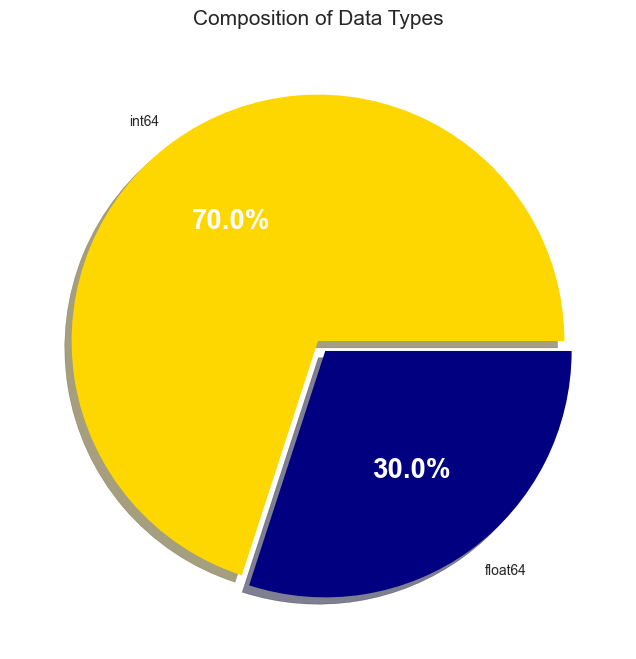

In [36]:
#Look into the size of the dataset
print('The dataset contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

#Describe the type of columns
print('\nThese are the columns and the type of data they contain:')
print(df.dtypes)

#To visualize the percentage I create a pie chart
freq = Counter(list(df.dtypes))
freq = pd.DataFrame.from_dict(freq, orient='index')

fig, ax = plt.subplots(figsize = (8, 8))
_, _, freq_pie = plt.pie(freq[0], labels = ['int64', 'float64'], colors = ['gold', 'navy'],
                         explode = [0, .05], shadow = True, autopct='%1.1f%%')
plt.setp(freq_pie, **{'color' : 'white', 'weight':'bold', 'fontsize' : 20})
plt.title('Composition of Data Types', fontsize = 15)
plt.show()

In [37]:
df.describe()

,num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,amount_paid
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.962000,4.897000,794.703420,0.376000,0.798000,0.477000,24684.986550,1.078000,0.608000,600.396359
std,1.030348,2.007591,147.771736,0.484622,0.401693,0.499721,9678.228224,0.934232,0.488441,181.406210
min,-1.000000,-1.000000,244.400000,0.000000,0.000000,0.000000,-1576.440000,0.000000,0.000000,87.851850
25%,1.000000,4.000000,691.037500,0.000000,1.000000,0.000000,18036.762500,0.000000,0.000000,475.065141
50%,2.000000,5.000000,789.970000,0.000000,1.000000,0.000000,24742.575000,1.000000,1.000000,598.331726
75%,3.000000,6.000000,892.955000,1.000000,1.000000,1.000000,31402.357500,2.000000,1.000000,729.930489
max,5.000000,11.000000,1189.120000,1.000000,1.000000,1.000000,56531.080000,4.000000,1.000000,1102.994109


C:\Users\mughe\AppData\Local\Temp\ipykernel_18748\2713080298.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


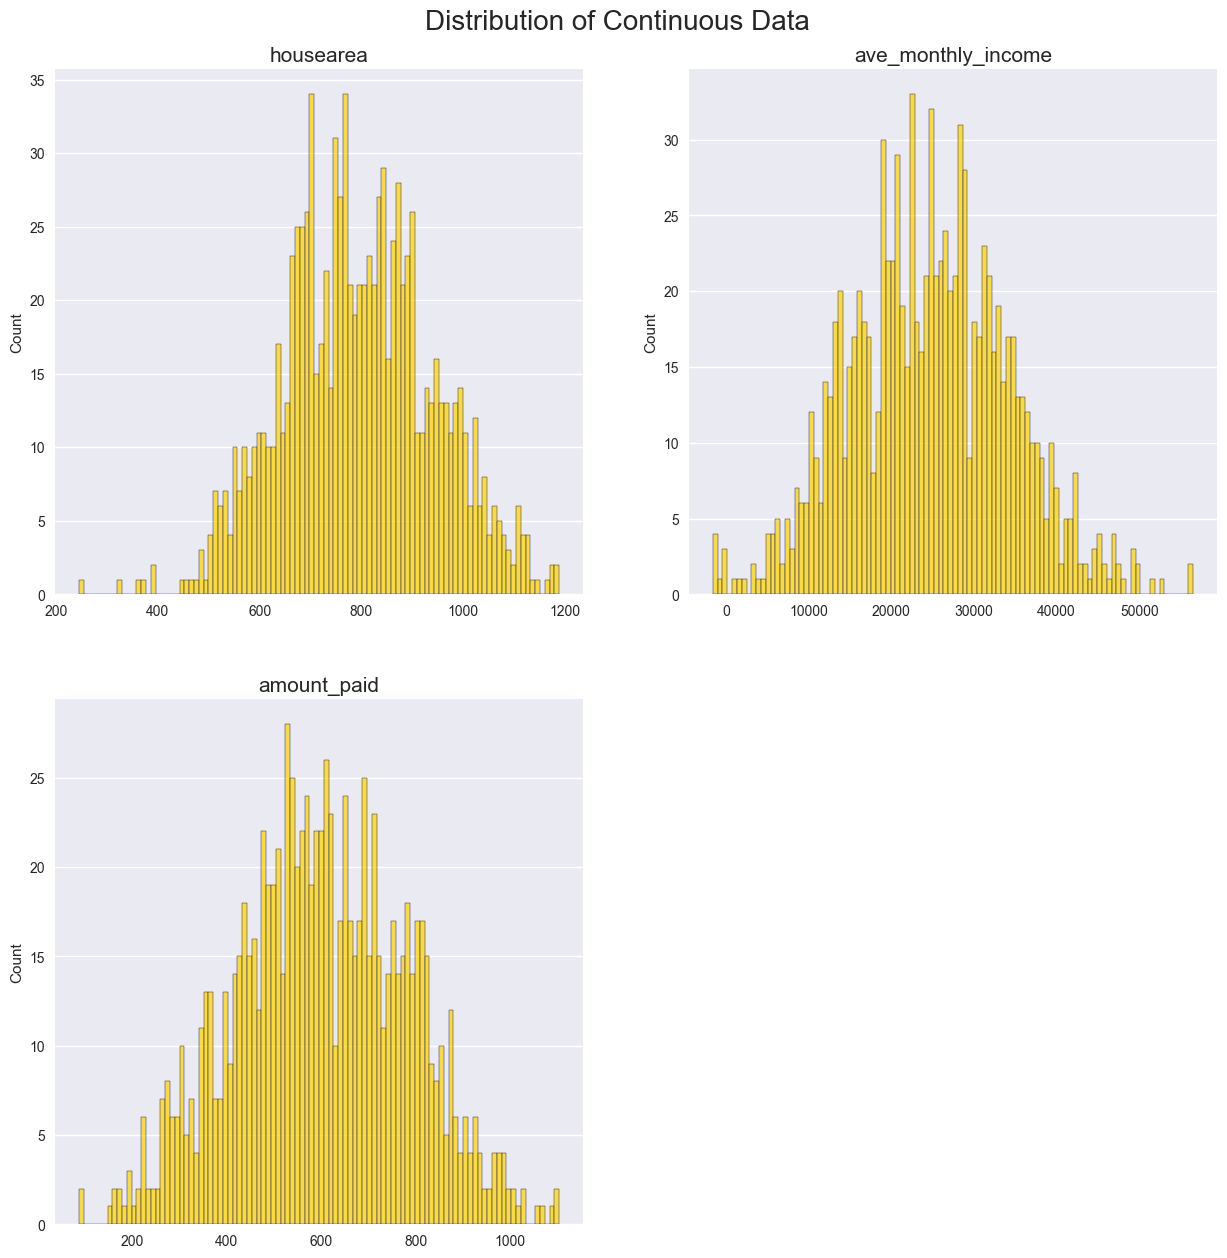

In [38]:
#Separate the continuous columns first
is_numeric = []
for col in df.columns:
    is_numeric.append(df[col].dtypes == 'float64')
df_numeric = df.columns[is_numeric]

#Create the histograms
plt.style.use('seaborn')
fig, axes = plt.subplots(2, 2, figsize = (15, 15))
axes[1][1].remove()

i = 0
for ax_group in axes:
    for axis in ax_group:
        if i == 3:
            continue
        else:
            sns.histplot(df[df_numeric[i]], bins = 100, ax = axis, color = 'gold', edgecolor = 'navy')
            axis.set_xlabel('')
            axis.grid(axis = 'x')
            axis.set_title(df_numeric[i], fontsize = 15)
        i = i+1
plt.suptitle('Distribution of Continuous Data', fontsize = 20, y = .92)
plt.show()

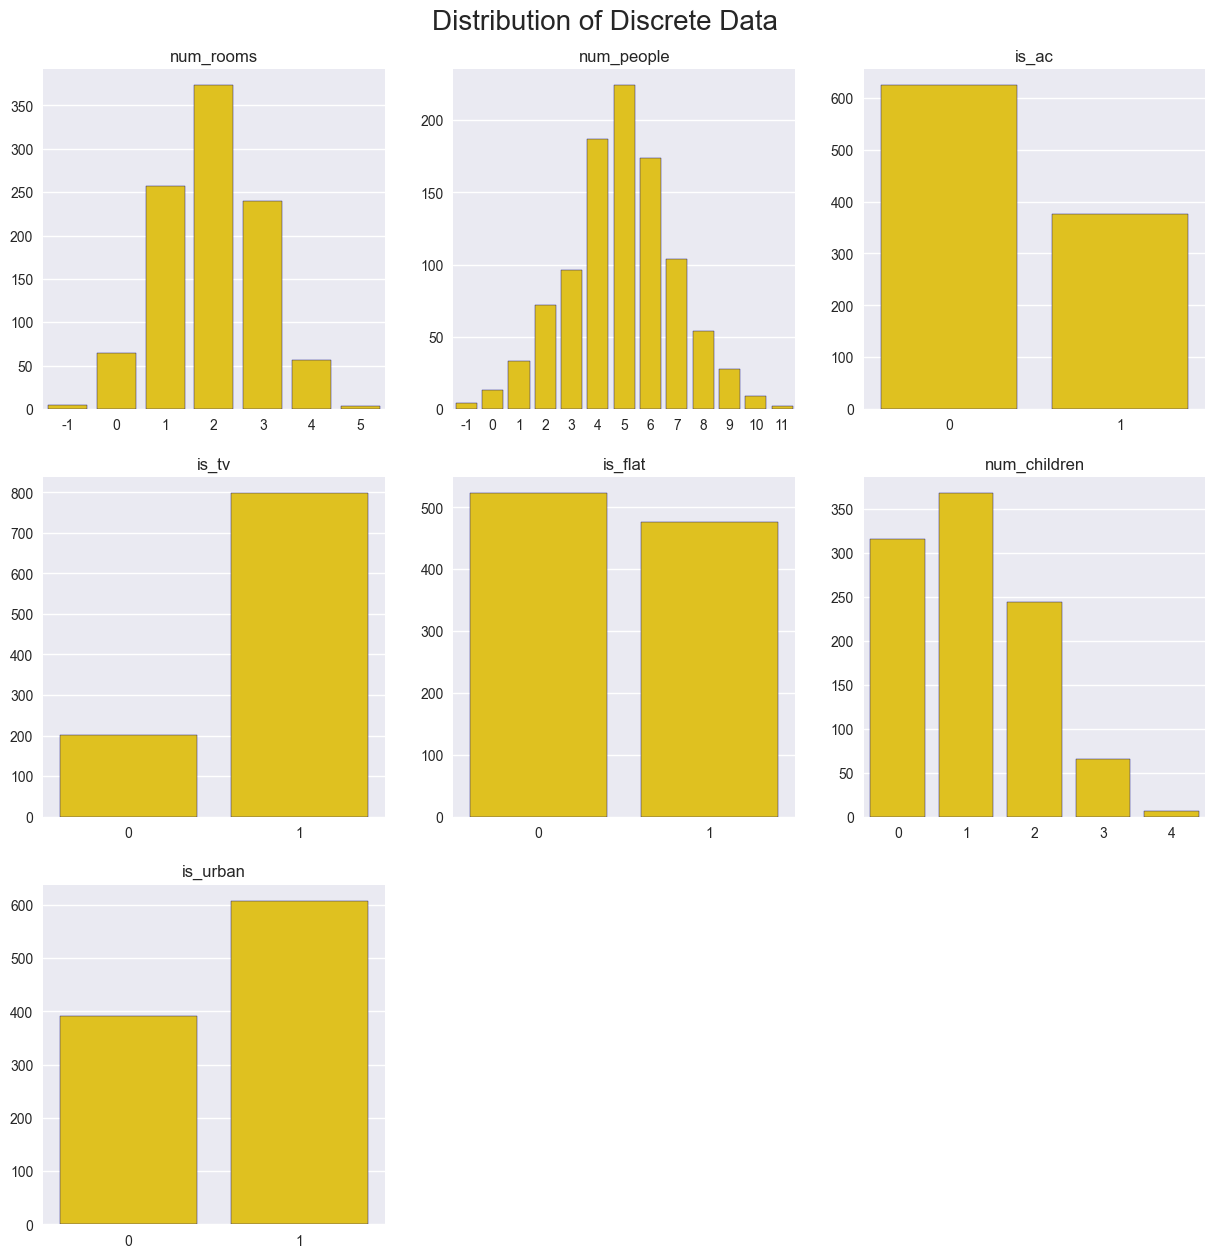

In [39]:
#Take the discrete columns, which are all the other ones
discrete = [not x for x in is_numeric]
df_discrete = df.columns[discrete]

#Create the histograms
fig, axes = plt.subplots(3, 3, figsize = (15,15))
axes[2][1].remove()
axes[2][2].remove()

i = 0
j = 0
for col in df_discrete:
    unique_values = df[col].unique()
    unique_values.sort()
    count_unique = []
    
    for values in unique_values:
        count_unique.append((df[col] == values).sum())
    
    sns.barplot(x = unique_values, y = count_unique, ax = axes[j][i], color = 'gold', edgecolor = 'navy')
    axes[j][i].set_title(col)
    
    if i == 2:
        j = j + 1
        i = 0
    else:
        i = i + 1
plt.suptitle('Distribution of Discrete Data', fontsize = 20, y = .92)
plt.show()

It is not logical for a house to have -1 rooms or people, so I will change those values to 0. Also, some values in ave_monthly_income are negative, these will be changed to the mean of the column.

In [40]:
df.loc[df['num_rooms'] <= 0, 'num_rooms'] = round(df['num_rooms'].mean())
df.loc[df['num_people'] <= 0, 'num_people'] = round(df['num_people'].mean())

df.loc[df['ave_monthly_income'] < 0, 'ave_monthly_income'] = df['ave_monthly_income'].mean()

Next, I will see if the dataset contains any duplicated rows or null values. The second one will be achieved by text and by visual representation showing white rectangles for null values.

The dataset contains 0 duplicated rows.


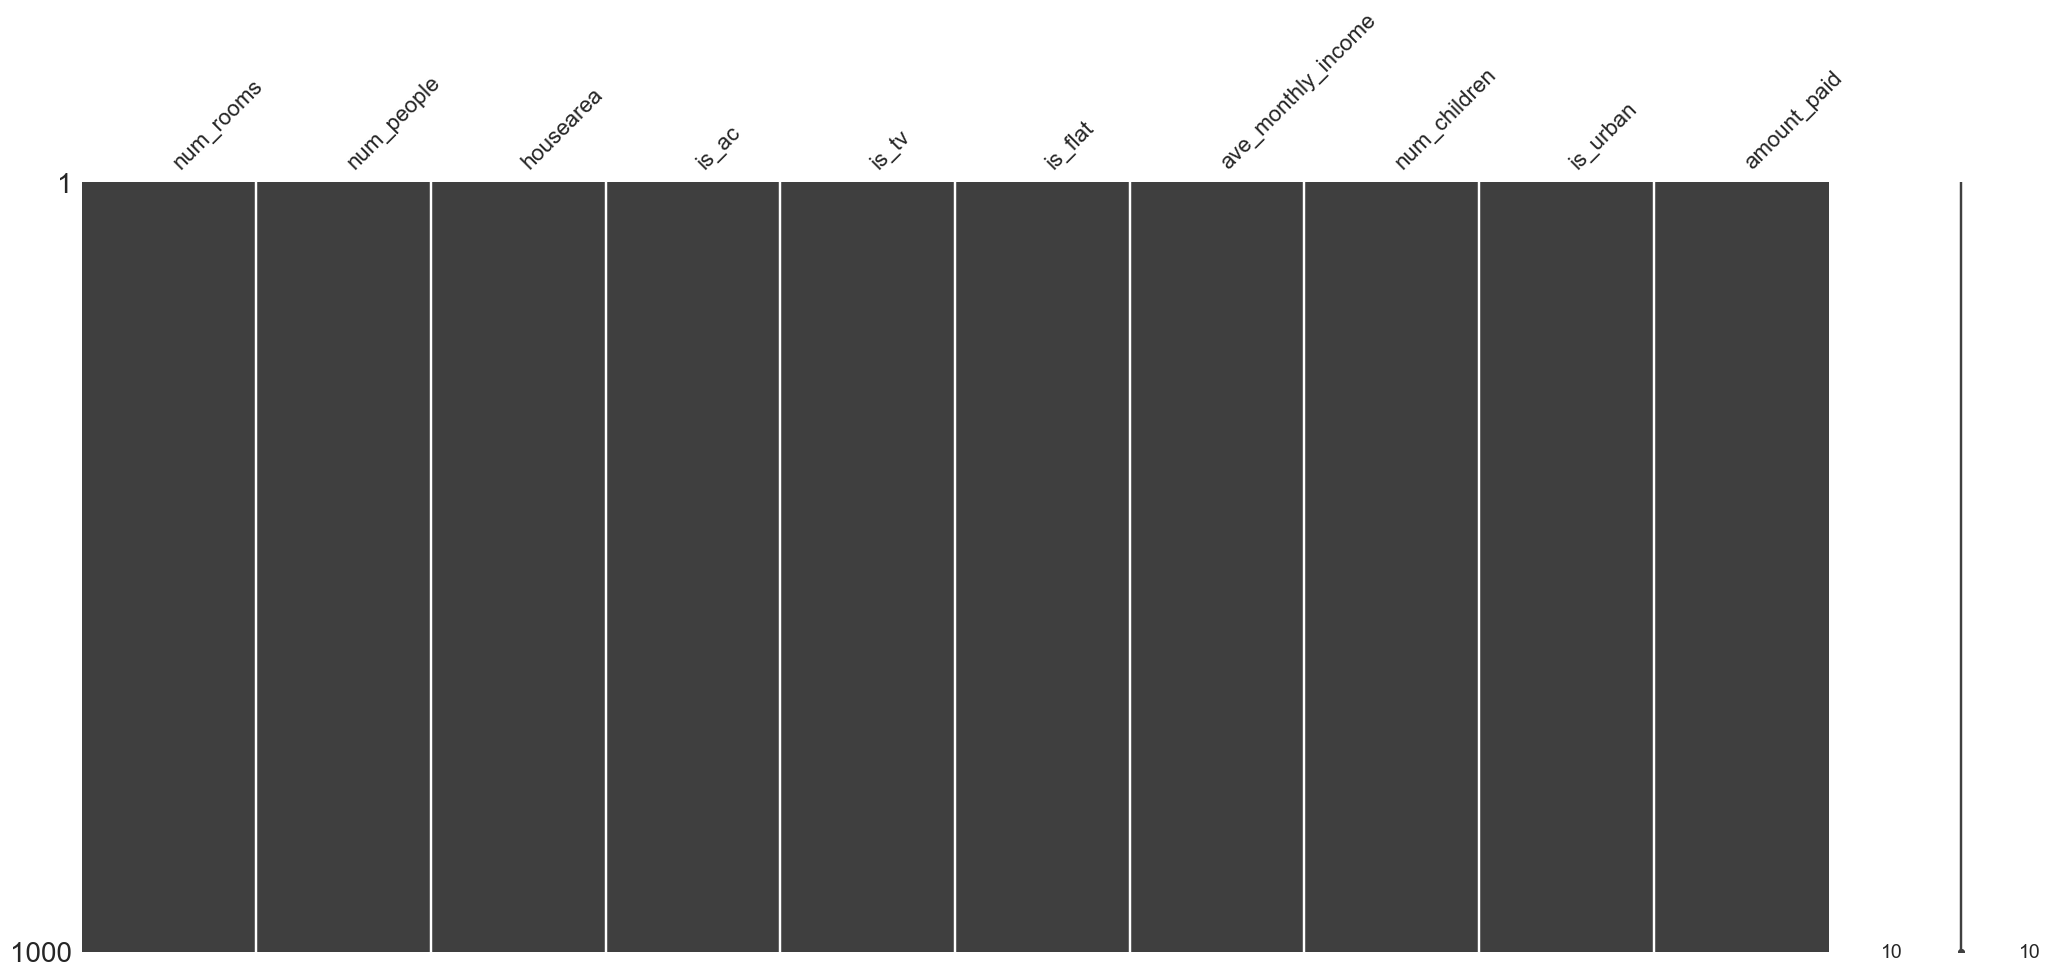

In [41]:
#Check the duplicated rows
print('The dataset contains {} duplicated rows.'.format(df.duplicated().sum()))

#Represent the null values in the columns
msno.matrix(df)
plt.show()

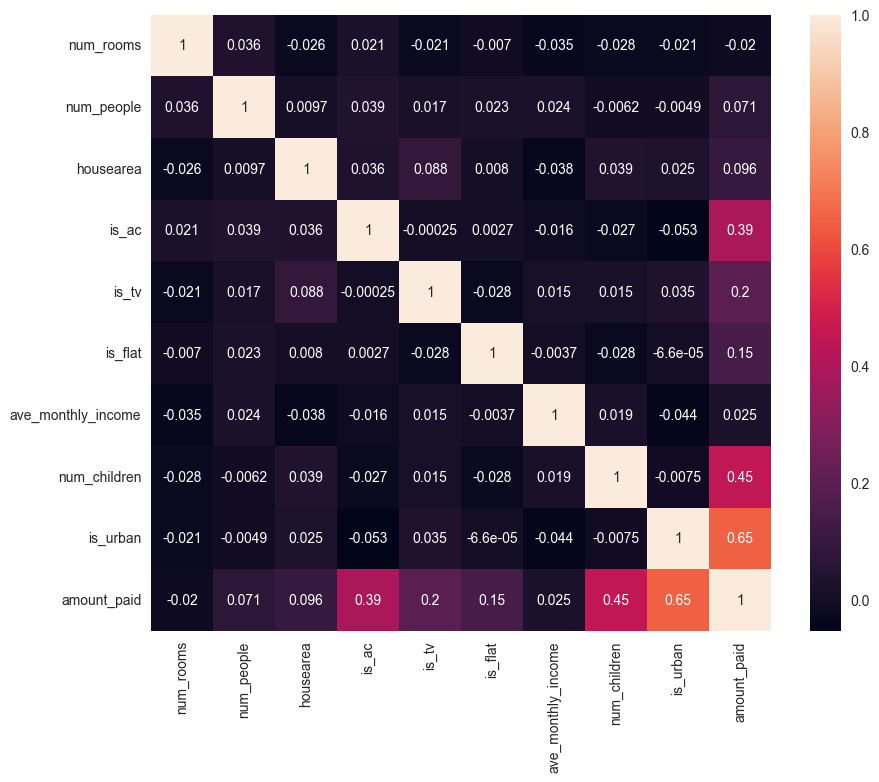

In [42]:
#Create a correlation heatplot
plt.figure(figsize = (10, 8))
sns.heatmap(df.corr(), annot = True)
plt.show()

# Data Transformation

The second stage is to prepare the data to make it easier for the model to understand it and process it.

Some of the columns contain high values, like ave_monthly_income, which goes to over 50,000, on the other hand, columns like num_rooms have 5 as the highest value. This will cause the model to give more weight to ave_monthly_income in the predictions.

In [43]:
#Create a list of the columns that will need to be transformed
scale_columns = ['num_rooms', 'num_people', 'housearea', 'ave_monthly_income', 'num_children']
df[scale_columns].head()

,num_rooms,num_people,housearea,ave_monthly_income,num_children
0,3,3,742.57,9675.93,2
1,1,5,952.99,35064.79,1
2,3,1,761.44,22292.44,0
3,2,5,861.32,12139.08,0
4,1,8,731.61,17230.10,2


In [44]:
#Create the scaler
scaler = StandardScaler()

#Scale the columns previously selected and replace them in the dataset
df[scale_columns] = scaler.fit_transform(df[scale_columns])
df.head()

,num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,amount_paid
0,1.034220,-1.051426,-0.352973,1,1,1,-1.601661,0.987401,0,560.481447
1,-1.282062,0.007412,1.071692,0,1,0,1.080224,-0.083533,1,633.283679
2,1.034220,-2.110264,-0.225213,1,1,1,-0.268949,-1.154467,0,511.879157
3,-0.123921,0.007412,0.451033,1,1,0,-1.341473,-1.154467,0,332.992035
4,-1.282062,1.595669,-0.427179,0,1,0,-0.803696,0.987401,1,658.285625


Now that the columns are scaled, the range is -3 to 3, but the proportion between the numbers is the same.

There is no need to scale the other columns because they are binary.

Before training the models I will check if any of the features have a low variance, meaning they do not change much and so they do not affect the model.

In [45]:
#Create the selector
vt = VarianceThreshold()

#Apply the selector on the features
features = df.iloc[:, :9]
vt = vt.fit_transform(features)

#Compare the shape of the features and the selector to see if any feature was removed
print('The dataset contains {} features.'.format(features.shape[1]))
print('The selector contains {} features.'.format(vt.shape[1]))

The dataset contains 9 features.
The selector contains 9 features.


In [46]:
#Select all the columns except the last one as features
x = df.iloc[:, :9]

#Select amount_paid as the target variable
y = df['amount_paid']

#The train set will have 80% of the data and the other 20% will be for testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 9)

# Testing Models

The third stage is to create a model that will accurately understand and imitate the relationship between the features and the target variable.

Because I am looking at how a number gets affected by different variables, this is a problem of regression. And because I will input the target variable into the model, this is supervised machine learning.

I will train 9 models and because each model has different parameters I will hypertune them to find the most appropriate ones for the model. This will be done by first using RandomizedSearchCV to pick random values inside a big range, training the model. Then, I will take the parameters that output the best score and use GridSearchCV to train the model on parameters on a smaller range around them.

I will create an empty Dataframe where I will store the best scores to compare them at the end.

In [47]:
scores = pd.DataFrame(columns = ['Random Search', 'Grid Search'])

# Linear Regression

In [48]:
#Ordinary least squares Linear Regression.
#Create the estimator
model_LR = LinearRegression()

#Train the model
model_LR.fit(x_train,y_train)

#Create predictions based on the test set
y_pred = model_LR.predict(x_test)

#Evaluate the predictions with the coefficient of determination (R^2)
results_linear = r2_score(y_test, y_pred)

#Store the scores
scores = scores.append({'Random Search' : results_linear, 'Grid Search' : results_linear},
                       ignore_index = True)

C:\Users\mughe\AppData\Local\Temp\ipykernel_18748\1294681741.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({'Random Search' : results_linear, 'Grid Search' : results_linear},


# Ridge

In [49]:
#Linear least squares with l2 regularization.
#Create the estimator
model_R = Ridge(random_state = 9)

#Create the grid search inputing the estimator, parameters and cross validation value
grid_R = GridSearchCV(model_R,
                      {'alpha' : [0, .25, .5, .75, 1]},
                      cv = 10)

#Train the models
grid_R.fit(x, y)

#Create a Dataframe with the results of the search
results_R = pd.DataFrame(grid_R.cv_results_).sort_values('mean_test_score',
                                                         ascending = False)

#Keep only the parameter tested and its score
results_R = results_R[['param_alpha', 'mean_test_score']]

#Store the scores
scores = scores.append({'Random Search' : results_R.iloc[0, -1], 'Grid Search' : results_R.iloc[0, -1]},
                       ignore_index = True)

#Show the results
results_R

C:\Users\mughe\AppData\Local\Temp\ipykernel_18748\3813969745.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({'Random Search' : results_R.iloc[0, -1], 'Grid Search' : results_R.iloc[0, -1]},


,param_alpha,mean_test_score
4,1,0.875090
3,0.75,0.875089
2,0.5,0.875085
1,0.25,0.875080
0,0,0.875072


# Lasso

In [50]:
#Linear Model trained with L1 prior as regularizer (aka the Lasso)
#Create the estimator
model_La = Lasso(random_state = 9)

#Create the grid search inputing the estimator, parameters and cross validation value
grid_La = GridSearchCV(model_La,
                       {'alpha' : [.1, .25, .5, .75, 1]},
                       cv = 10)

#Train the models
grid_La.fit(x, y)

#Create a Dataframe with the results of the search
results_La = pd.DataFrame(grid_La.cv_results_).sort_values('mean_test_score',
                                                           ascending = False)

#Keep only the parameter tested and its score
results_La = results_La[['param_alpha', 'mean_test_score']]

#Store the scores
scores = scores.append({'Random Search' : results_La.iloc[0, -1], 'Grid Search' : results_La.iloc[0, -1]},
                       ignore_index = True)

#Show the results
results_La

C:\Users\mughe\AppData\Local\Temp\ipykernel_18748\1202127478.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({'Random Search' : results_La.iloc[0, -1], 'Grid Search' : results_La.iloc[0, -1]},


,param_alpha,mean_test_score
2,0.5,0.875228
1,0.25,0.875199
3,0.75,0.875164
0,0.1,0.875133
4,1,0.875010


#  Decision Tree Regressor

In [59]:
#Create the estimator
model_DTR = DecisionTreeRegressor(random_state = 9)

#Create the random search inputing the estimator, parameters,
#number of iterations and cross validation value
random_DTR = RandomizedSearchCV(model_DTR,
                                {'max_depth' : np.arange(10, 210, 10).tolist(),
                                 'min_weight_fraction_leaf' : [.1, .2, .3, .4, .5],
                                 'max_features' : ['auto', 'sqrt', 'log2', None],          
                                 'max_leaf_nodes' : np.arange(10, 110, 10).tolist()},
                                n_iter = 100,
                                cv = 5,
                                random_state = 9)
                                
#Train the models
random_DTR.fit(x, y)

#Create a Dataframe with the results of the search
results_raDTR = pd.DataFrame(random_DTR.cv_results_).sort_values('mean_test_score',
                                                                 ascending = False)

#Keep only the parameters tested and its scores
results_raDTR = results_raDTR[['param_max_depth',
                               'param_min_weight_fraction_leaf',
                               'param_max_features',
                               'param_max_leaf_nodes',
                               'mean_test_score']]

#Show the parameters with the highest score
results_raDTR.loc[(results_raDTR['mean_test_score'] == results_raDTR['mean_test_score'].max())]

C:\Users\mughe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\mughe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\mughe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\tree\_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_feature

,param_max_depth,param_min_weight_fraction_leaf,param_max_features,param_max_leaf_nodes,mean_test_score
70,40,0.1,auto,30,0.67803
37,150,0.1,auto,30,0.67803
38,40,0.1,auto,70,0.67803
44,10,0.1,None,80,0.67803
6,180,0.1,auto,90,0.67803
7,130,0.1,None,60,0.67803
49,10,0.1,None,10,0.67803
69,190,0.1,auto,40,0.67803
13,70,0.1,None,50,0.67803


In [60]:
#Create the estimator. This will have max_features set to None,
#since None and auto both are equal to n_features
model_DTR = DecisionTreeRegressor(random_state = 9)

#Create the grid search inputing the estimator, parameters and cross validation value
grid_DTR = GridSearchCV(model_DTR,
                        {'max_depth' : np.arange(8, 20, 2).tolist(),
                         'min_weight_fraction_leaf' : [.05, .1, .15, .2],
                         'max_leaf_nodes' : np.arange(10, 110, 10).tolist()},
                        cv = 10)

#Train the models
grid_DTR.fit(x, y)

#Create a Dataframe with the results of the search
results_grDTR = pd.DataFrame(grid_DTR.cv_results_).sort_values('mean_test_score',
                                                               ascending = False)

#Keep only the parameters tested and their scores
results_grDTR = results_grDTR[['param_max_depth',
                               'param_min_weight_fraction_leaf',
                               'param_max_leaf_nodes',
                               'mean_test_score']]

#Show the parameters with the highest score and lowest max_depth
results_grDTR.loc[(results_grDTR['mean_test_score'] == results_grDTR['mean_test_score'].max())
                & (results_grDTR['param_max_depth'] == results_grDTR['param_max_depth'].min())]

,param_max_depth,param_min_weight_fraction_leaf,param_max_leaf_nodes,mean_test_score
32,8,0.05,90,0.781072
36,8,0.05,100,0.781072
28,8,0.05,80,0.781072
8,8,0.05,30,0.781072
12,8,0.05,40,0.781072
16,8,0.05,50,0.781072
4,8,0.05,20,0.781072
20,8,0.05,60,0.781072
24,8,0.05,70,0.781072


In [61]:
#Store the scores
scores = scores.append({'Random Search' : results_raDTR.iloc[0, -1], 'Grid Search' : results_grDTR.iloc[0, -1]},
                       ignore_index = True)

C:\Users\mughe\AppData\Local\Temp\ipykernel_18748\3055822191.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({'Random Search' : results_raDTR.iloc[0, -1], 'Grid Search' : results_grDTR.iloc[0, -1]},


# Random Forest

In [62]:
#Create the estimator
model_RFR = RandomForestRegressor(random_state = 9)

#Create the random search inputing the estimator, parameters,
#number of iterations and cross validation value
random_RFR = RandomizedSearchCV(model_RFR,
                                {'n_estimators': np.arange(100, 1100, 100).tolist(),
                                 'max_depth' : np.arange(50, 160, 10).tolist(),
                                 'min_weight_fraction_leaf' : [.1, .2, .3, .4, .5],
                                 'max_features' : ['auto', 'sqrt', 'log2', None],
                                 'max_leaf_nodes' : np.arange(10, 60, 10).tolist(),
                                 'bootstrap' : [True, False]},
                                n_iter = 100,
                                cv = 5,
                                random_state = 9)

#Train the models
random_RFR.fit(x, y)

#Create a Dataframe with the results of the search
results_raRFR = pd.DataFrame(random_RFR.cv_results_).sort_values('mean_test_score',
                                                                 ascending = False)

#Keep only the parameters tested and their scores
results_raRFR = results_raRFR[['param_n_estimators',
                               'param_max_depth',
                               'param_min_weight_fraction_leaf',
                               'param_max_features',
                               'param_max_leaf_nodes',
                               'param_bootstrap',
                               'mean_test_score']]

#Show the parameters with the highest score
results_raRFR.loc[(results_raRFR['mean_test_score'] == results_raRFR['mean_test_score'].max())]

C:\Users\mughe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\mughe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
C:\Users\mughe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packag

,param_n_estimators,param_max_depth,param_min_weight_fraction_leaf,param_max_features,param_max_leaf_nodes,param_bootstrap,mean_test_score
58,200,100,0.1,auto,30,True,0.710555


In [68]:
#Create the estimator
model_RFR = RandomForestRegressor(random_state = 9)

#Create the grid search inputing the estimator, parameters and cross validation value
grid_RFR = GridSearchCV(model_RFR,
                        {'n_estimators': np.arange(180, 230, 10).tolist(),
                         'max_depth' : np.arange(80, 130, 10).tolist(),
                         'min_weight_fraction_leaf' : [.05, .1, .15],
                         'max_leaf_nodes' : np.arange(20, 45, 5).tolist()},
                        cv = 10)

#Train the models
grid_RFR.fit(x, y)

#Create a Dataframe with the results of the search
results_grRFR = pd.DataFrame(grid_RFR.cv_results_).sort_values('mean_test_score',
                                                               ascending = False)

#Keep only the parameters tested and their scores
results_grRFR = results_grRFR[['param_n_estimators',
                               'param_max_depth',
                               'param_min_weight_fraction_leaf',
                               'param_max_leaf_nodes',
                               'mean_test_score']]

#Show the parameters with the highest score
results_grRFR.loc[(results_grRFR['mean_test_score'] == results_grRFR['mean_test_score'].max())]

,param_n_estimators,param_max_depth,param_min_weight_fraction_leaf,param_max_leaf_nodes,mean_test_score
0,180,80,0.05,20,0.800311
15,180,80,0.05,25,0.800311
135,180,90,0.05,40,0.800311
300,180,120,0.05,20,0.800311
30,180,80,0.05,30,0.800311
165,180,100,0.05,25,0.800311
360,180,120,0.05,40,0.800311
45,180,80,0.05,35,0.800311
270,180,110,0.05,35,0.800311
180,180,100,0.05,30,0.800311


In [69]:
#Store the scores
scores = scores.append({'Random Search' : results_raRFR.iloc[0, -1], 'Grid Search' : results_grRFR.iloc[0, -1]},
                       ignore_index = True)

C:\Users\mughe\AppData\Local\Temp\ipykernel_18748\2519863505.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({'Random Search' : results_raRFR.iloc[0, -1], 'Grid Search' : results_grRFR.iloc[0, -1]},


# Support Vector Regression

In [51]:

#Create the estimator
model_SVR = SVR()

#Create the random search inputing the estimator, parameters,
#number of iterations and cross validation value
random_SVR = RandomizedSearchCV(model_SVR,
                                {'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
                                 'degree' : np.arange(1, 7, 1).tolist(),
                                 'gamma' : ['scale', 'auto'],
                                 'C' : np.arange(2, 22, 2).tolist(),
                                 'epsilon' : [.1, .25, .5, .75]},
                                n_iter = 100,
                                cv = 5,
                                random_state = 9)
               
#Train the models
random_SVR.fit(x, y)

#Create a Dataframe with the results of the search
results_raSVR = pd.DataFrame(random_SVR.cv_results_).sort_values('mean_test_score',
                                                                 ascending = False)

#Keep only the parameters tested and their scores
results_raSVR = results_raSVR[['param_kernel',
                               'param_degree',
                               'param_gamma',
                               'param_C',
                               'param_epsilon',
                               'mean_test_score']]

#Show the parameters with the highest score
results_raSVR.loc[(results_raSVR['mean_test_score'] == results_raSVR['mean_test_score'].max())]

,param_kernel,param_degree,param_gamma,param_C,param_epsilon,mean_test_score
90,linear,4,scale,20,0.5,0.873202
60,linear,1,auto,20,0.5,0.873202
73,linear,2,scale,20,0.5,0.873202


In [70]:
#Create the estimator with kernel as lineal and degree and gamma as default
model_SVR = SVR(kernel = 'linear')

#Create the grid search inputing the estimator, parameters and cross validation value
grid_SVR = GridSearchCV(model_SVR,
                        {'C' : np.arange(18, 23, 1).tolist(),
                         'epsilon' : [.3, .4, .5, .6]},
                        cv = 10)

#Train the models
grid_SVR.fit(x, y)

#Create a Dataframe with the results of the search
results_grSVR = pd.DataFrame(grid_SVR.cv_results_).sort_values('mean_test_score',
                                                               ascending = False)

#Keep only the parameters tested and their scores
results_grSVR = results_grSVR[['param_C',
                               'param_epsilon',
                               'mean_test_score']]

#Show the parameters with the highest score
results_grSVR.loc[(results_grSVR['mean_test_score'] == results_grSVR['mean_test_score'].max())]

,param_C,param_epsilon,mean_test_score
15,21,0.6,0.872558


In [71]:
#Store the scores
scores = scores.append({'Random Search' : results_raSVR.iloc[0, -1], 'Grid Search' : results_grSVR.iloc[0, -1]},
                       ignore_index = True)

C:\Users\mughe\AppData\Local\Temp\ipykernel_18748\647439646.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({'Random Search' : results_raSVR.iloc[0, -1], 'Grid Search' : results_grSVR.iloc[0, -1]},


#  K-Nearest Neighbors

In [72]:
#Create the estimator
model_KNN = KNeighborsRegressor()

#Create the random search inputing the estimator, parameters,
#number of iterations and cross validation value
random_KNN = RandomizedSearchCV(model_KNN,
                                {'n_neighbors' : np.arange(5, 55, 5).tolist(),
                                 'weights' : ['uniform', 'distance'],
                                 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
                                 'leaf_size' : np.arange(5, 55, 5).tolist(),
                                 'p' : [1, 2]},
                                n_iter = 100,
                                cv = 5,
                                random_state = 9)
               
#Train the models
random_KNN.fit(x, y)

#Create a Dataframe with the results of the search
results_raKNN = pd.DataFrame(random_KNN.cv_results_).sort_values('mean_test_score',
                                                                 ascending = False)

#Keep only the parameters tested and their scores
results_raKNN = results_raKNN[['param_n_neighbors',
                               'param_weights',
                               'param_algorithm',
                               'param_leaf_size',
                               'param_p',
                               'mean_test_score']]

#Show the parameters with the highest score
results_raKNN.loc[(results_raKNN['mean_test_score'] == results_raKNN['mean_test_score'].max())]

,param_n_neighbors,param_weights,param_algorithm,param_leaf_size,param_p,mean_test_score
30,10,distance,brute,30,1,0.733295
29,10,distance,ball_tree,15,1,0.733295


In [73]:
#Create the estimator with the values define from the random search
model_KNN = KNeighborsRegressor(weights = 'distance', p = 1)

#Create the grid search inputing the estimator, parameters and cross validation value
grid_KNN = GridSearchCV(model_KNN,
                        {'n_neighbors' : np.arange(8, 13, 1).tolist(),
                         'algorithm' : ['ball_tree', 'brute'],
                         'leaf_size' : np.arange(10, 34, 2).tolist()},
                        cv = 10)

#Train the models
grid_KNN.fit(x, y)

#Create a Dataframe with the results of the search
results_grKNN = pd.DataFrame(grid_KNN.cv_results_).sort_values('mean_test_score',
                                                               ascending = False)
#Keep only the parameters tested and their scores
results_grKNN = results_grKNN[['param_n_neighbors',
                               'param_algorithm',
                               'param_leaf_size',
                               'mean_test_score']]

#Show the parameters with the highest score
results_grKNN.loc[(results_grKNN['mean_test_score'] == results_grKNN['mean_test_score'].max())]

,param_n_neighbors,param_algorithm,param_leaf_size,mean_test_score
41,9,ball_tree,26,0.736124
51,9,ball_tree,30,0.736124
26,9,ball_tree,20,0.736124
61,9,brute,10,0.736124
71,9,brute,14,0.736124
1,9,ball_tree,10,0.736124
76,9,brute,16,0.736124
21,9,ball_tree,18,0.736124
31,9,ball_tree,22,0.736124
81,9,brute,18,0.736124


In [74]:
#Store the scores
scores = scores.append({'Random Search' : results_raKNN.iloc[0, -1], 'Grid Search' : results_grKNN.iloc[0, -1]},
                       ignore_index = True)

C:\Users\mughe\AppData\Local\Temp\ipykernel_18748\4005414901.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({'Random Search' : results_raKNN.iloc[0, -1], 'Grid Search' : results_grKNN.iloc[0, -1]},


# Gradient Boosting Regressor

In [54]:
#Create the estimator
model_GBR = GradientBoostingRegressor(random_state = 9)

#Create the random search inputing the estimator, parameters,
#number of iterations and cross validation value
random_GBR = RandomizedSearchCV(model_GBR,
                                {'loss' : ['ls', 'lad', 'huber', 'quantile'],
                                 'learning_rate' : [.1, .25, .5, .75],
                                 'n_estimators' : np.arange(10, 90, 10).tolist(),
                                 'min_weight_fraction_leaf' : [.1, .2, .3, .4, .5],
                                 'max_depth' : [5, 10, 20, 30],
                                 'max_features' : ['auto', 'sqrt', 'log2', None]},
                                n_iter = 100,
                                cv = 5,
                                random_state = 9)
                                
#Train the models
random_GBR.fit(x, y)

#Create a Dataframe with the results of the search
results_raGBR = pd.DataFrame(random_GBR.cv_results_).sort_values('mean_test_score',
                                                                 ascending = False)

#Keep only the parameters tested and their scores
results_raGBR = results_raGBR[['param_loss',
                               'param_learning_rate',
                               'param_n_estimators',
                               'param_min_weight_fraction_leaf',
                               'param_max_depth',
                               'param_max_features',
                               'mean_test_score']]

#Show the parameters with the highest score
results_raGBR.loc[(results_raGBR['mean_test_score'] == results_raGBR['mean_test_score'].max())]

C:\Users\mughe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(
C:\Users\mughe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(
C:\Users\mughe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_gb.py:301: FutureWarning: The loss 'lad' was deprecated in v1.0 and will be removed in version 1.2. Use 'absolute_error' which is equivalent.
  warnings.warn(
C:\Users\mughe\AppData\Local\Packages\PythonSoftware

,param_loss,param_learning_rate,param_n_estimators,param_min_weight_fraction_leaf,param_max_depth,param_max_features,mean_test_score
19,huber,0.25,30,0.1,10,sqrt,0.849049


In [55]:
#Create the estimator with the values define from the random search
model_GBR = GradientBoostingRegressor(loss = 'huber', random_state = 9)

#Create the grid search inputing the estimator, parameters and cross validation value
grid_GBR = GridSearchCV(model_GBR,
                        {'learning_rate' : [.2, .25, .30, .35],
                         'n_estimators' : np.arange(40, 65, 5).tolist(),
                         'min_weight_fraction_leaf' : [.05, .1, .15, .2],
                         'max_depth' : [25, 30, 35]},
                        cv = 10)
                                
#Train the models
grid_GBR.fit(x, y)

#Create a Dataframe with the results of the search
results_grGBR = pd.DataFrame(grid_GBR.cv_results_).sort_values('mean_test_score',
                                                               ascending = False)

#Keep only the parameters tested and their scores
results_grGBR = results_grGBR[['param_learning_rate',
                               'param_n_estimators',
                               'param_min_weight_fraction_leaf',
                               'param_max_depth',
                               'mean_test_score']]

#Show the parameters with the highest score
results_grGBR.loc[(results_grGBR['mean_test_score'] == results_grGBR['mean_test_score'].max())]

,param_learning_rate,param_n_estimators,param_min_weight_fraction_leaf,param_max_depth,mean_test_score
0,0.2,40,0.05,25,0.854344
20,0.2,40,0.05,30,0.854344
40,0.2,40,0.05,35,0.854344


# Extreme Gradient Boosting

In [56]:
#Create the estimator
model_XGB = XGBRegressor(random_state = 9)

#Create the random search inputing the estimator, parameters,
#number of iterations and cross validation value
random_XGB = RandomizedSearchCV(model_XGB,
                                {'eta' : [.1, .2, .3, .4, .5],
                                 'max_depth' : np.arange(10, 60, 10).tolist(),
                                 'min_child_weight' : np.arange(5, 35, 5).tolist(),
                                 'subsample' : [.1, .2, .3, .4, .5],
                                 'colsample_bytree' : [.1, .2, .3, .4, .5]},
                                n_iter = 100,
                                cv = 5,
                                random_state = 9)
                                
#Train the models
random_XGB.fit(x, y)

#Create a Dataframe with the results of the search
results_raXGB = pd.DataFrame(random_XGB.cv_results_).sort_values('mean_test_score',
                                                                 ascending = False)

#Keep only the parameters tested and their scores
results_raXGB = results_raXGB[['param_eta',
                               'param_max_depth',
                               'param_min_child_weight',
                               'param_subsample',
                               'param_colsample_bytree',
                               'mean_test_score']]

#Show the parameters with the highest score
results_raXGB.loc[(results_raXGB['mean_test_score'] == results_raXGB['mean_test_score'].max())]

,param_eta,param_max_depth,param_min_child_weight,param_subsample,param_colsample_bytree,mean_test_score
82,0.1,20,15,0.3,0.5,0.859307


In [57]:
#Create the estimator
model_XGB = XGBRegressor(random_state = 9)

#Create the grid search inputing the estimator, parameters and cross validation value
grid_XGB = GridSearchCV(model_XGB,
                        {'eta' : [.05, .1, .15, .2],
                         'max_depth' : np.arange(6, 16, 2).tolist(),
                         'min_child_weight' : np.arange(16, 26, 2).tolist(),
                         'subsample' : [.4, .5, .6],
                         'colsample_bytree' : [.4, .5, .6]},
                        cv = 10)
                                
#Train the models
grid_XGB.fit(x, y)

#Create a Dataframe with the results of the search
results_grXGB = pd.DataFrame(grid_XGB.cv_results_).sort_values('mean_test_score',
                                                               ascending = False)

#Keep only the parameters tested and their scores
results_grXGB = results_grXGB[['param_eta',
                               'param_max_depth',
                               'param_min_child_weight',
                               'param_subsample',
                               'param_colsample_bytree',
                               'mean_test_score']]

#Show the parameters with the highest score
results_grXGB.loc[(results_grXGB['mean_test_score'] == results_grXGB['mean_test_score'].max())]

,param_eta,param_max_depth,param_min_child_weight,param_subsample,param_colsample_bytree,mean_test_score
703,0.1,8,24,0.5,0.6,0.863224


In [66]:
#Store the scores
scores = scores.append({'Random Search' : results_raXGB.iloc[0, -1], 'Grid Search' : results_grXGB.iloc[0, -1]},
                       ignore_index = True)

C:\Users\mughe\AppData\Local\Temp\ipykernel_18748\1179970723.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({'Random Search' : results_raXGB.iloc[0, -1], 'Grid Search' : results_grXGB.iloc[0, -1]},


# Selecting Model

C:\Users\mughe\AppData\Local\Temp\ipykernel_18748\48522809.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


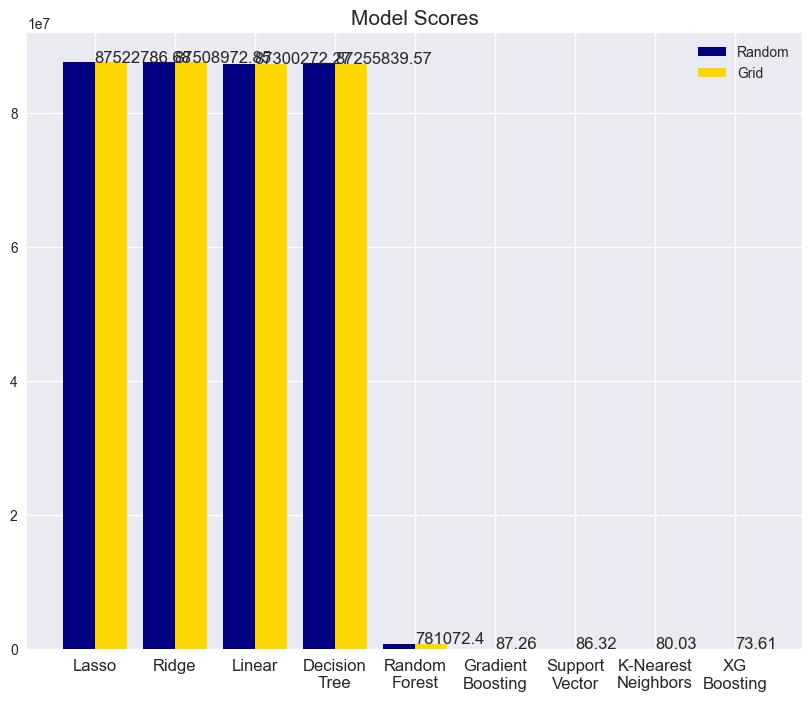

In [75]:
#Multiply the scores by 100 to make it easier to read
scores = scores * 100

#Add the name of the model to every pair of scores and sort it in descending order
model_labels = ['Linear','Ridge', 'Lasso', 'Decision\nTree', 'Random\nForest', 'Support\nVector', 'K-Nearest\nNeighbors', 'Gradient\nBoosting', 'XG\nBoosting']
scores.index = model_labels
scores = scores.sort_values('Grid Search', ascending = False)

#Create the bar plot
w = .4
bar1 = np.arange(len(scores))
bar2 = [i+w for i in bar1]

plt.style.use('seaborn')
plt.figure(figsize = (10, 8))
bar_random=plt.bar(bar1, scores['Random Search'], w, label = 'Random', color = 'navy')
bar_grid=plt.bar(bar2, scores['Grid Search'], w, label = 'Grid', color = 'gold')

#Format the plot
plt.xticks(bar1 + (w/2), scores.index, fontsize = 12)
plt.legend()
plt.title('Model Scores', fontsize = 15)

#Add labels on top of the bars to make the comparison easier
for index, value in enumerate(scores['Grid Search']):
    plt.text(index + (w/2), value + .5, str(round(value, 2)), fontsize = 12)

C:\Users\mughe\AppData\Local\Temp\ipykernel_18748\1412597780.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  final_bar = sns.barplot(x = bar_df.index, y = bar_df['Score'], palette = palette)


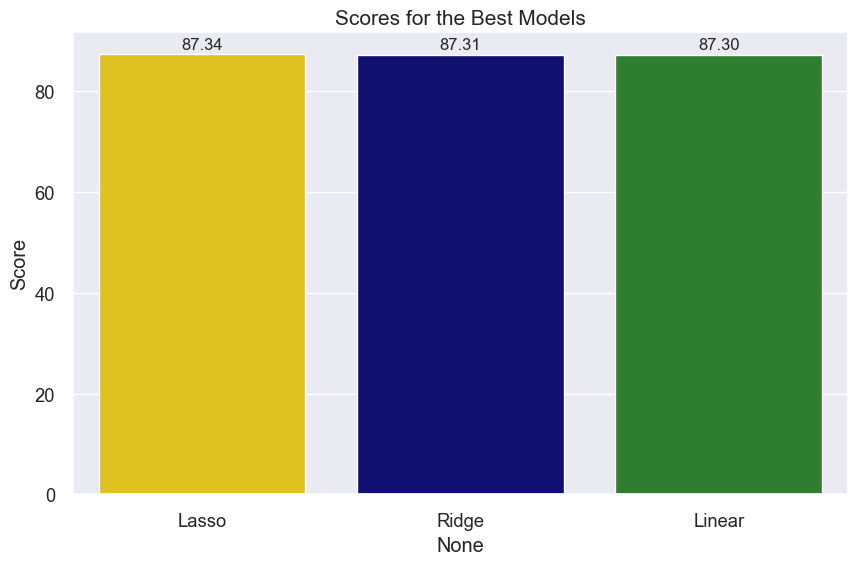

In [76]:
#Create the estimators with the best parameters
Ridge_final = Ridge(alpha = 1, random_state = 10)
Lasso_final = Lasso(alpha = .5, random_state = 10)
Linear_final = LinearRegression()

#Train the models using the train data
Ridge_final.fit(x_train, y_train)
Lasso_final.fit(x_train, y_train)
Linear_final.fit(x_train, y_train)

#Create prediction values using the test data
Ridge_predict = Ridge_final.predict(x_test)
Lasso_predict = Lasso_final.predict(x_test)
Linear_predict = Linear_final.predict(x_test)

#Evaluate the predictions with R^2
Ridge_score = r2_score(y_test, Ridge_predict)
Lasso_score = r2_score(y_test, Lasso_predict)
Linear_score = r2_score(y_test, Linear_predict)

#Group the scores and the model names
bar_x = ['Ridge', 'Lasso', 'Linear']
bar_y = [Ridge_score * 100, Lasso_score * 100, Linear_score * 100]

#Create a Dataframe and sort the values
bar_df = pd.DataFrame(bar_y, bar_x, columns = ['Score'])
bar_df = bar_df.sort_values('Score', ascending = False)

#Create the plot
sns.set(font_scale = 1.2)
plt.figure(figsize = (10, 6))
palette = ['gold', 'navy', 'forestgreen']
final_bar = sns.barplot(x = bar_df.index, y = bar_df['Score'], palette = palette)

#Add labels on top of the bars to make the comparison easier
for p in final_bar.patches:
    final_bar.annotate(format(p.get_height(), '.2f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 7), size = 12,
                       textcoords = 'offset points')

plt.title('Scores for the Best Models', fontsize = 15)
plt.show()

Feature Importance

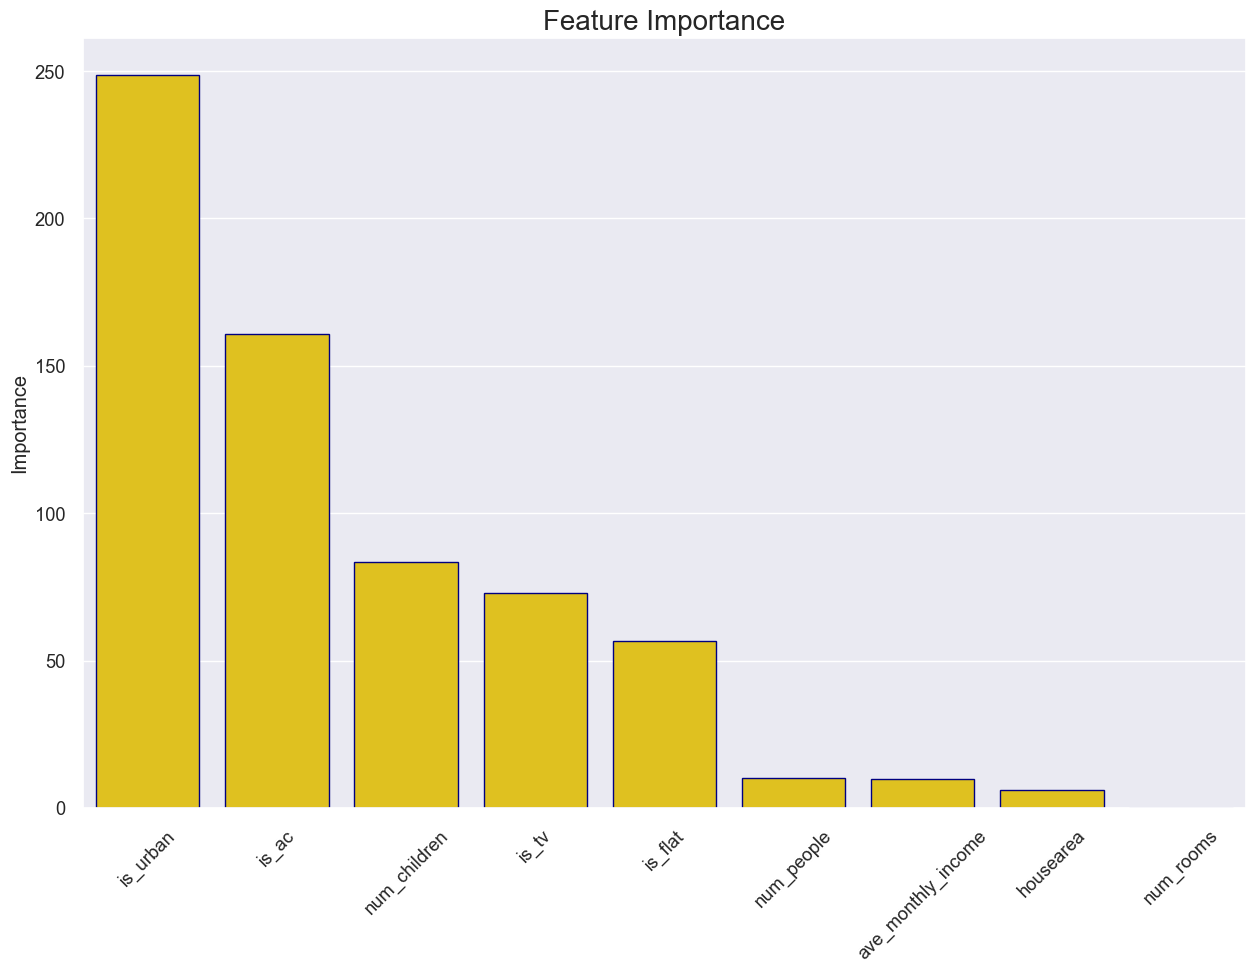

In [78]:
#Access the feature coefficients from the trained model and get the absolute value
importance = Lasso_final.coef_
importance = np.abs(importance)

#Create a Dataframe of each feature and its importance
feature_importance = pd.DataFrame(list(zip(x_train.columns, importance)),
                                 columns = ['Feature', 'Importance'])

#Sort Dataframe by Importance in descending order
feature_importance = feature_importance.sort_values('Importance',
                                                    ascending = False).reset_index(drop = True)

#Create a bar plot
plt.figure(figsize = (15, 10))
sns.barplot(x = feature_importance['Feature'], y = feature_importance['Importance'], color = 'gold', edgecolor = 'navy')
plt.xticks(rotation = 45)
plt.xlabel('')
plt.title('Feature Importance', fontsize = 20)
plt.show()


C:\Users\mughe\AppData\Local\Temp\ipykernel_18748\322835252.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x = 'Category', y = 'amount_paid', data = urban_df, palette = palette)


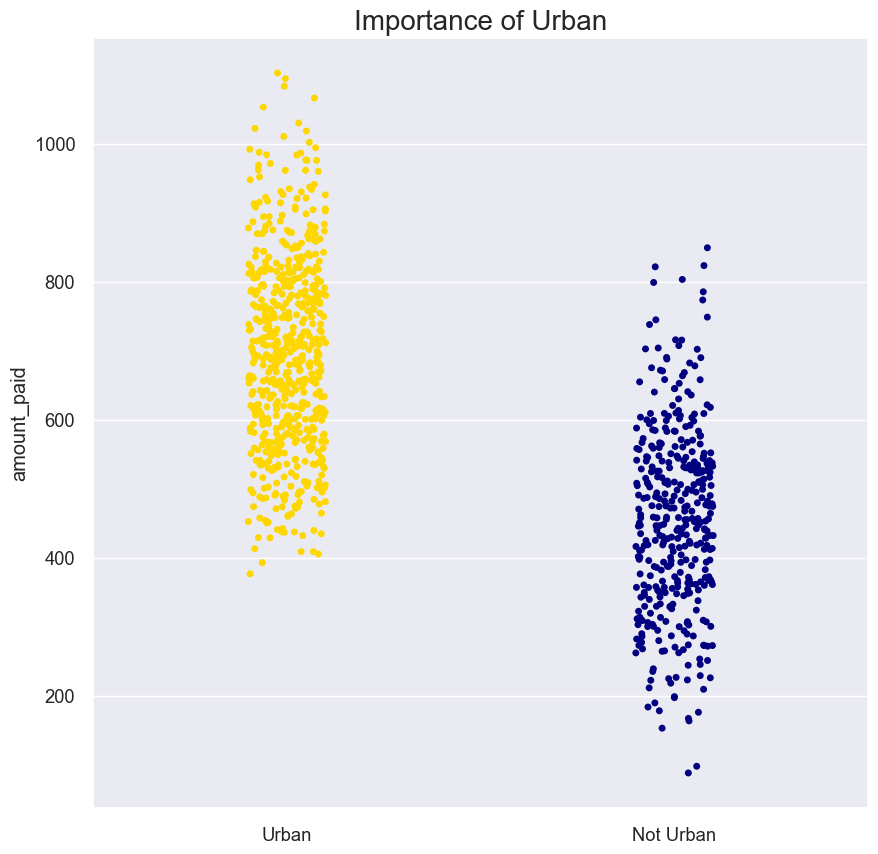

In [79]:
#Take amount_paid into a list depending on the value of is_urban
urban = df.loc[df['is_urban'] == 1, 'amount_paid']
not_urban = df.loc[df['is_urban'] == 0, 'amount_paid']

#Join the lists
urban_df = pd.concat([urban, not_urban]).reset_index(drop = True)

#Create a Dataframe
urban_df = pd.DataFrame(urban_df)

#Add a column to label the row as urban or not urban
urban_df['Category'] = np.where(urban_df.index >= len(urban), 'Not Urban', 'Urban')

#Create the plot
plt.figure(figsize = (10, 10))
palette = ['gold', 'navy']
sns.stripplot(x = 'Category', y = 'amount_paid', data = urban_df, palette = palette)
plt.xlabel('')
plt.title('Importance of Urban', fontsize = 20);

Comparing Values

In [80]:
#Join predicted y and true y and create a Dataframe
y_values = list(zip(y_test, Lasso_predict))
y_values = pd.DataFrame(y_values, columns = ['Target', 'Prediction'])

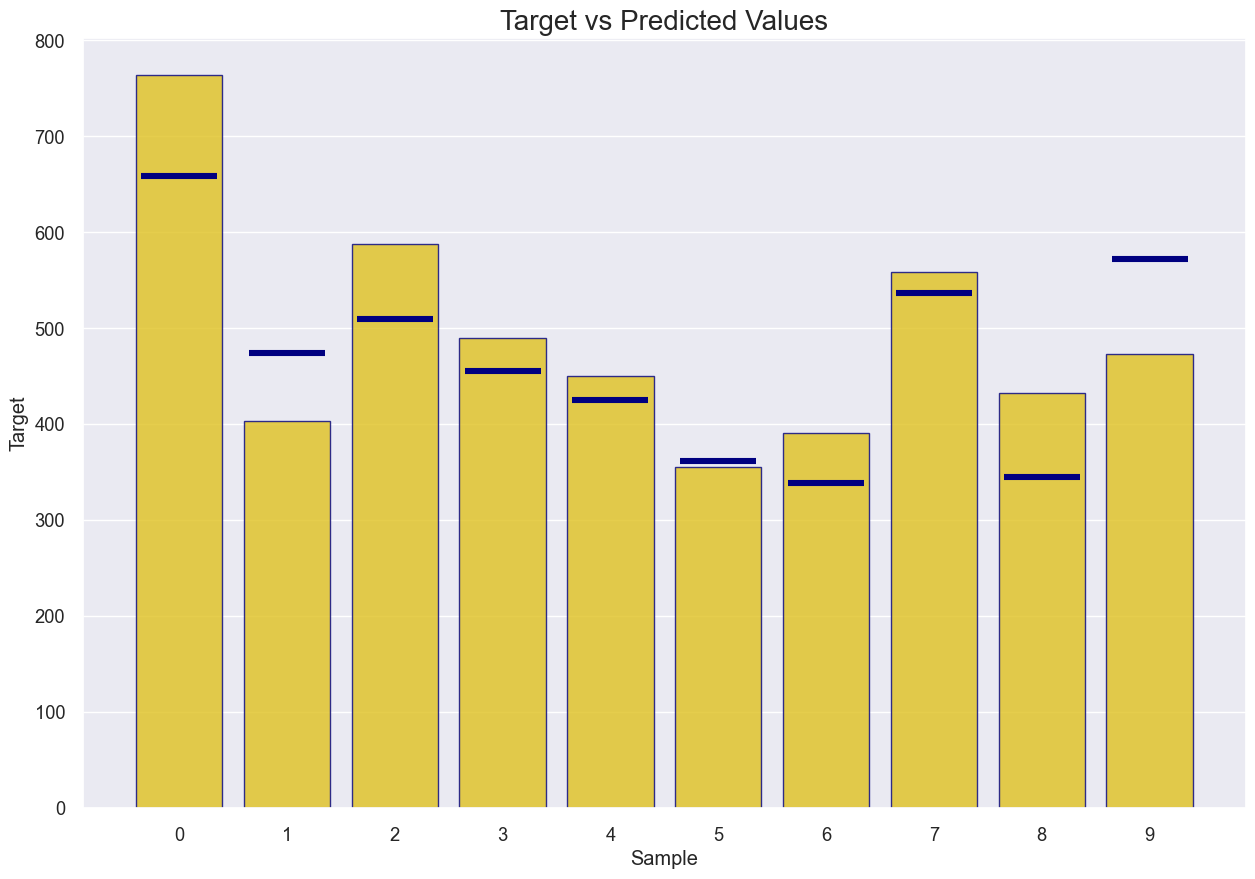

In [81]:
#Take 10 random samples from the Dataframe
sample = y_values.sample(10).reset_index(drop = True)

#Create the plot
plt.figure(figsize = (15, 10))

#This will be for the true values
sns.barplot(x = sample.index, y = sample['Target'], color = 'gold', edgecolor = 'navy', alpha = .8)

#This will be just a horizontal line to represent the predicted value
sns.scatterplot(x = sample.index, y = sample['Prediction'], color = 'navy',
                marker = '_', s = 3000)
plt.xlabel('Sample')
plt.title('Target vs Predicted Values', fontsize = 20)
plt.show()

The Lasso model has proven to be a reliable model to predict the price in an electric bill based on the characteristics of a house and its inhabitants, it has an accuracy of 87.31%.

This model can be implemented by electric companies to give their users a good estimate of what they can expect to pay at the end of the month. On the other side, electric companies can benefit from this by translating amount_paid into kilowatts consumed. By knowing how much energy their clients will use, companies can calculate in advance how much power they need to produce.

